# PRMT-2409

## Context

As the GP Connect and Adapter teams continue to build out their solutions and get ready to test them, they want some data from us to help them understand the type of use cases they need to be able too handle. 

# Questions to answer

How long do GP2GP transfers take? - from the point the transfer is initiated (requested made), to the point where either the last COPC is acknowledged, or request started acknowledgement (for the case where there are no COPCs).

 - What proportion go within 24 hours
 - What proportion go between 24 hours - 3 days?
 - What proportion go between 3-5 days?
 - What proportion go between 5-8 days?
 - What proportion go over 8 days, but do eventually complete?

## Scope

Produce a breakdown of integration times

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

# Show all columns
pd.set_option('display.max_columns', None)

In [2]:
# The "raw" SPINE messages will be used to find the last sender message of each successful transfer
spine_messages_files= [
    "s3://prm-gp2gp-raw-spine-data-preprod/v2/messages/2021/7/2021-7_spine_messages.csv.gz",
    "s3://prm-gp2gp-raw-spine-data-preprod/v2/messages/2021/8/2021-8_spine_messages.csv.gz",
    "s3://prm-gp2gp-raw-spine-data-preprod/v2/messages/2021/9/2021-9_spine_messages.csv.gz"
]

spine_messages = (
    pd.concat((pd.read_csv(f, dtype=str) for f in spine_messages_files))
      .rename(columns={"conversationID": "conversation_id"})
      .set_index("conversation_id")
)

In [3]:
# The transfers dataset will be used to find a set of successful transfers started in a given month
transfer_file_location = "s3://prm-gp2gp-transfer-data-preprod/v5/2021/7/2021-7-transfers.parquet"
transfers =  pd.read_parquet(transfer_file_location).set_index('conversation_id')

In [4]:
# Coerce all datetimes into uct. This will allow them to be compared.
spine_messages["_time"] = pd.to_datetime(spine_messages["_time"])
transfers["date_completed"] = pd.to_datetime(transfers["date_completed"], utc=True)
transfers["date_requested"] = pd.to_datetime(transfers["date_requested"], utc=True)

# Duration of successful transfers

## Aproach to inferring transfer duration

Using SPINE logs, its not possible to accurately measure how long a transfer takes.

This is primarilly due to the fact there is no single message that pin points the moment at which a GP2GP record has entirely been recived by the requesting system and is ready for a human to integrate.

Instead, we can use the last message returned by the sender as an aproximation of how long the transfer took.

To simplify ananlysis, we shall only consider transfers that were successfuly integrated.

Here is how this methololody works for different variations in GP2GP.

### Significance of using the last sender message

First consider the case case of the normal happy path transfer, without large messaging.
In this scenario, the last message sent by the sending practice will either be the core EHR, or the acknowlegment of request - which are known to be sent in quick succession, but in any order.

```

 Aproximating transfer duration without COPC
 ▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔

Requester                               Sender
    │                                     │
    │ ───────── GP2GP Request ──────────▶ │ ┐
    │                                     │ │── Assumed duration of transfer
    │ ◀─── Acknowlegement of Request ──── │ │
    │                                     │ │
    │ ◀─────────── Core EHR ───────────── │ ┘
    │                                     │
    │ ─── Acknowlegement of CORE EHR ───▶ │
    
    
```

The other main variation of GP2GP transfer is one in which common point to point messaging is used to transmit records bigger than 5mb in a series of chunks.
In this case the last message returned by the sender will be the final COPC fragment.

```

   Aproximating transfer duration with COPC
   ▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔▔

Requester                               Sender
    │                                     │
    │ ───────── GP2GP Request ──────────▶ │ ┐
    │                                     │ │
    │ ◀─── Acknowlegement of Request ──── │ │
    │                                     │ │
    │ ◀----------- Core EHR ───────────── │ │
    │                                     │ │── Assumed duration of transfer
    │ ───────── COPC Continue ──────────▶ │ │
    │                                     │ │
    │ ◀─────── COPC Fragment 1 ────────── │ │
    │                                     │ │
    │ ──── Acknowlegement of COPC 1 ────▶ │ │
    │                                     │ │
    │                ...                  │ │
    │                                     │ │
    │ ◀─────── COPC Fragment N ────────── │ ┘
    │                                     │ 
    │ ──── Acknowlegement of COPC N ────▶ │ 
    │                                     │
    │ ─── Acknowlegement of CORE EHR ───▶ │

    
    
```
### Transfers with duplicates

Some GP2GP transfers have more than Core EHR returned by the sender.

This means that the above methodology will potentially not always measure the time taken to transfer a single record.


There are two main examples of how duplicates core EHRs can affect the accuracy of our analysis. In both cases, having a manifest describing which COPC messages belong to which core EHR transfer attempt would help significantly. This might be possible using SPINE GP2GP attachment metadata.

#### Interleaved Duplicate Core EHR

Sometimes several core EHR will be returned in quick succession. Often in this case the requestor picks one to integrrate and responds to the others with an error. If we naivly take the last message sent be sender, it might not be the EHR which was eventually integrated.

```

Requester                               Sender
    │                                     │
    │ ───────── GP2GP Request ──────────▶ │ ┐
    │                                     │ │── Assumed duration of transfer
    │ ◀─── Acknowlegement of Request ──── │ │
    │                                     │ │
    │ ◀─────────── Core EHR 1 ─────────── │ │
    │                                     │ │
    │ ◀─────────── Core EHR 2 ─────────── │ ┘
    │                                     │
    │ ─── Negative Acknowlegement ──────▶ │
    │                                     │    
    │ ─── Positive Acknowlegement ──────▶ │
    

```
#### Sequential Duplicate Core EHR

Another pattern seen, is that after a failed transfer another core ehr will be sent and the transfer will "start again", often after a significatn time delay. In these scenarious measuring from the time of request to last message from sender would include not one, but several attempts at the transfer, including any pauses in between attempts.

```

Requester                               Sender
    │                                     │
    │ ───────── GP2GP Request ──────────▶ │ ┐
    │                                     │ │── Assumed duration of transfer
    │ ◀─── Acknowlegement of Request ──── │ │
    │                                     │ │
    │ ◀─────────── Core EHR 1 ─────────── │ │
    │                                     │ │
    │ ─── Negative Acknowlegement ──────▶ │ │
    │                                     │ │
    │ ◀─────────── Core EHR 2 ─────────── │ ┘
    │                                     │
    │ ─── Positive Acknowlegement ──────▶ │

```


<AxesSubplot:title={'center':'EHR transfer attempts made during GP2GP conversations (log scale)'}, xlabel='EHR Transfer attempts', ylabel='Number of GP2GP conversations'>

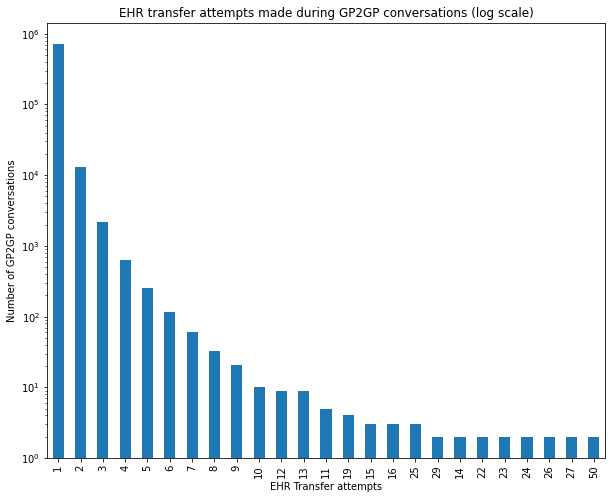

In [5]:
# To view the desired breakdown of transfer duration, with and without transfers with duplicate EHR transmission
# we need to determine the number of  EHRs sent in each conversation

is_ehr_request_completed = spine_messages["interactionID"] == "urn:nhs:names:services:gp2gp/RCMR_IN030000UK06"
ehr_req_completed_messages = spine_messages[is_ehr_request_completed]
ehr_count = ehr_req_completed_messages.groupby("conversation_id").size().to_frame("core_ehr_messages_sent")
ehr_count["core_ehr_messages_sent"].value_counts().plot.bar(
    log=True,
    title="EHR transfer attempts made during GP2GP conversations (log scale)",
    xlabel="EHR Transfer attempts",
    ylabel="Number of GP2GP conversations",
    figsize=(10,8)
)

In [6]:
# Find integrated transfers
is_integrated =  (transfers["status"] == "Integrated on time") | (transfers["failure_reason"] == "Integrated late")
integrated_transfers = transfers[is_integrated]

# Join in all messages, and the count of EHRs sent
successful_transfer_messages = integrated_transfers\
  .join(spine_messages, how="left")\
  .join(ehr_count, how="left")

# For each conversation, find the last sender message before integration
is_sender_message = successful_transfer_messages["messageSender"] == successful_transfer_messages["sending_practice_asid"]
is_before_integration = successful_transfer_messages["_time"] < successful_transfer_messages["date_completed"]
sender_messages_before_integration = successful_transfer_messages[is_sender_message & is_before_integration]

integrations = sender_messages_before_integration.sort_values("_time").groupby("conversation_id").tail(1)

# Check we still have all the transfers
print(integrated_transfers.shape)
print(integrations.shape)

(205795, 12)
(205795, 22)


In [7]:
has_single_ehr = integrations["core_ehr_messages_sent"] == 1
itegrations_with_single_ehr = integrations[has_single_ehr]

# '_time' in this case will be the time of the last sender message before integration
transfer_duration = integrations["_time"] - integrations["date_requested"]
single_ehr_transfer_duration = itegrations_with_single_ehr["_time"] - itegrations_with_single_ehr["date_requested"]

### Note: Due to how the transfers dataset is generated, transfers that integrated after 14 days are not included.

In [8]:
transfer_duration.describe()

count                       205795
mean     0 days 02:59:29.188810598
std      0 days 21:04:29.179641513
min         0 days 00:00:01.604000
25%         0 days 00:00:12.153000
50%         0 days 00:00:28.930000
75%         0 days 00:02:40.784000
max        13 days 20:24:10.846000
dtype: object

In [9]:
single_ehr_transfer_duration.describe()

count                       202456
mean     0 days 02:09:40.607698828
std      0 days 17:48:54.671319390
min         0 days 00:00:01.604000
25%         0 days 00:00:12.002000
50%         0 days 00:00:27.946000
75%         0 days 00:02:19.783000
max        13 days 18:30:32.071000
dtype: object

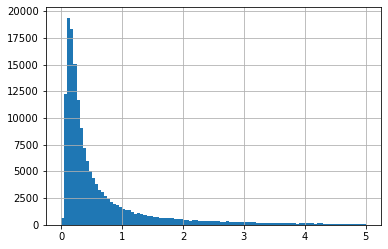

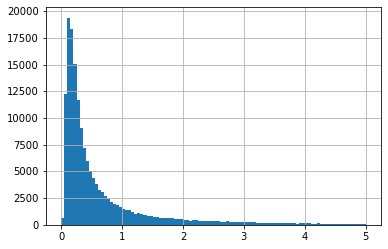

In [10]:
# First 5 min
(transfer_duration/ pd.Timedelta(minutes=1)).hist(bins=100, range=[0,5])
plt.show()
(single_ehr_transfer_duration/ pd.Timedelta(minutes=1)).hist(bins=100, range=[0,5])
plt.show()

In [11]:
def bucket(duration):
    if duration < timedelta(days=1):
        return "<1 day"
    elif duration < timedelta(days=3):
        return ">= 1 day and < 3 days"
    elif duration < timedelta(days=5):
        return ">= 3 days and < 5 days"
    elif duration < timedelta(days=8):
        return ">= 5 days and < 8 days"
    else:
        return ">= 8 days and < 14 days"

In [12]:
transfer_duration_bucketed = transfer_duration.apply(bucket)
single_ehr_transfer_duration_bucketed = single_ehr_transfer_duration.apply(bucket)

In [13]:
bucketed_counts = transfer_duration_bucketed.value_counts().to_frame("transfer_count").sort_index()
print("Bucketed counts, with duplicates:")
print(bucketed_counts)
print("Bucketed counts, without duplicates:")
single_ehr_bucketed_counts = single_ehr_transfer_duration_bucketed.value_counts().to_frame("transfer_count").sort_index()
print(single_ehr_bucketed_counts)


Bucketed counts, with duplicates:
                         transfer_count
<1 day                           200987
>= 1 day and < 3 days              1319
>= 3 days and < 5 days             1374
>= 5 days and < 8 days             1264
>= 8 days and < 14 days             851
Bucketed counts, without duplicates:
                         transfer_count
<1 day                           199040
>= 1 day and < 3 days               777
>= 3 days and < 5 days             1053
>= 5 days and < 8 days             1035
>= 8 days and < 14 days             551


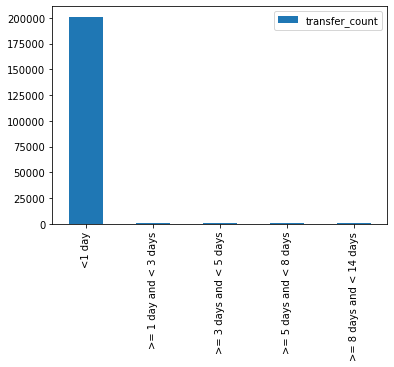

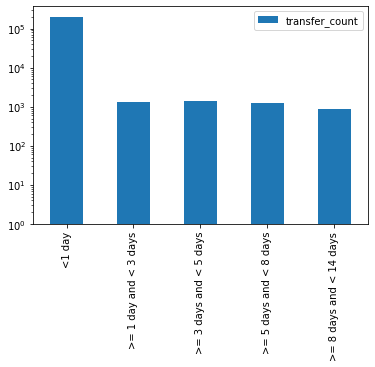

In [14]:
bucketed_counts.plot.bar()
plt.show()
bucketed_counts.plot.bar(log=True)
plt.show()

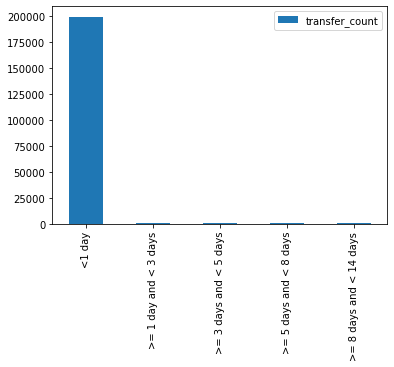

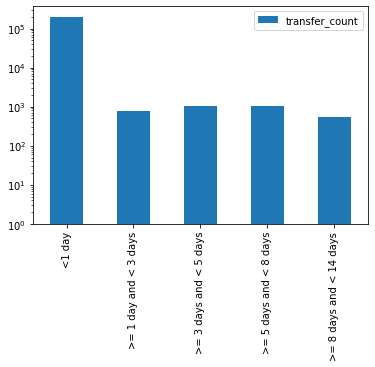

In [15]:
single_ehr_bucketed_counts.plot.bar()
plt.show()
single_ehr_bucketed_counts.plot.bar(log=True)
plt.show()

# Sender activity beyond 14 days

Another, more aproximate,but more generalisable approach to infering transfer duration
is to consider the time between first and last sender message, regardless of if or when the EHR was integrated.

This will allow us to measure sender activity beyond the 14 day limit imposed by the transfers dataset.

In [16]:
transfer_messages = transfers.join(spine_messages, how="left")
is_sender_message = transfer_messages["messageSender"] == transfer_messages["sending_practice_asid"]
sender_messages = transfer_messages[is_sender_message]
firstlast_messages = sender_messages.groupby("conversation_id").agg({'_time': [np.min, np.max]})
sender_deltas = firstlast_messages["_time"]["amax"] - firstlast_messages["_time"]["amin"]


In [17]:
print(transfers.shape)
print(sender_deltas.shape)

(227805, 12)
(226974,)


In [18]:
sender_deltas.describe()

count                       226974
mean     0 days 07:09:40.614773736
std      2 days 12:58:51.378504879
min                0 days 00:00:00
25%         0 days 00:00:01.463000
50%         0 days 00:00:06.444000
75%         0 days 00:01:37.053250
max        83 days 20:47:17.134000
dtype: object

In [19]:
def bucket_sender_delta(duration):
    if duration < timedelta(days=1):
        return "<1 day"
    elif duration < timedelta(days=3):
        return ">= 1 day and < 3 days"
    elif duration < timedelta(days=5):
        return ">= 3 days and < 5 days"
    elif duration < timedelta(days=8):
        return ">= 5 days and < 8 days"
    else:
        return ">= 8 days"

In [20]:
sender_delta_bucketed = sender_deltas.apply(bucket_sender_delta)

In [21]:
bucketed_sender_delta_counts = sender_delta_bucketed.value_counts().to_frame("transfer_count").sort_index()
bucketed_sender_delta_counts

,transfer_count
<1 day,219521
>= 1 day and < 3 days,1534
>= 3 days and < 5 days,1675
>= 5 days and < 8 days,1613
>= 8 days,2631


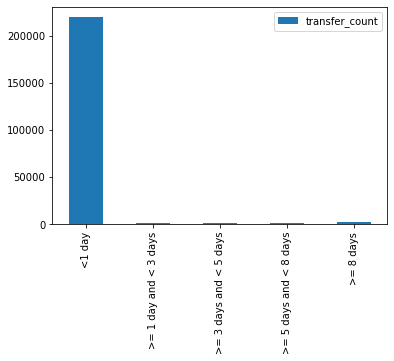

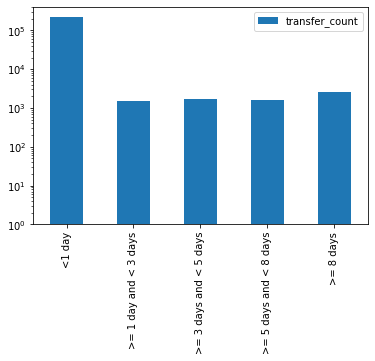

In [22]:
bucketed_sender_delta_counts.plot.bar()
plt.show()
bucketed_sender_delta_counts.plot.bar(log=True)
plt.show()